TF-IDF features shape: (14497, 46122)
Optimal number of clusters (k): 2 with silhouette score: 0.010331705139124516
Cluster 0: closed, 171, written statements, discussion, discussion closed, statements, written, article 171, statements article, closed vote
Cluster 1: european, mr, union, president, energy, europe, eu, commission, people, need

Cluster Interpretations:
- Cluster 0: Likely procedural or administrative discussions (e.g., 'closed', '171', 'written statements')
- Cluster 1: Likely broader EU governance and leadership topics (e.g., 'european', 'mr', 'union')


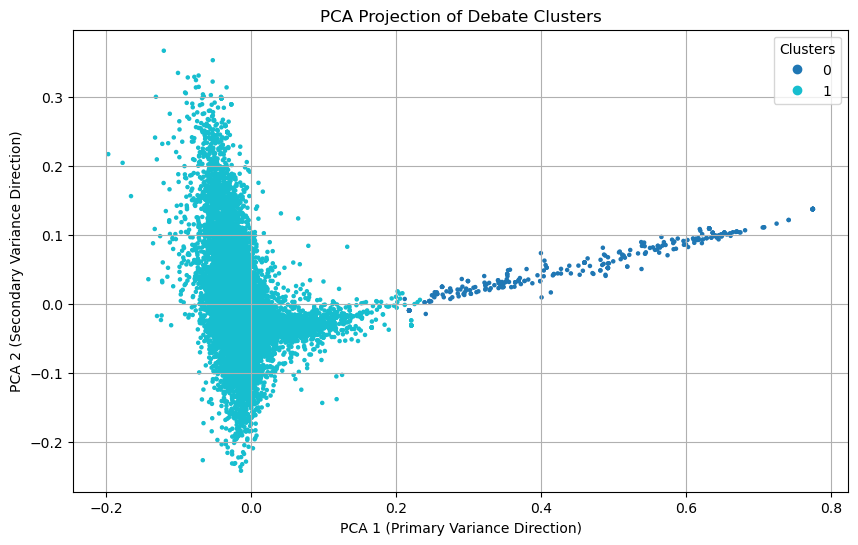

PCA Interpretation: PCA-1 and PCA-2 capture the main axes of variation in debate topics, highlighting cluster separation.

Cross-Validation Accuracy: 0.624 ± 0.070

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.34      0.48       559
           1       0.84      0.75      0.79       126
           2       0.76      0.74      0.75       636
           3       0.78      0.80      0.79      2030
           4       0.79      0.90      0.84      2261

    accuracy                           0.78      5612
   macro avg       0.79      0.70      0.73      5612
weighted avg       0.79      0.78      0.77      5612


Confusion Matrix:
[[ 190    8   41   94  226]
 [   0   94   30    2    0]
 [  12    9  471  140    4]
 [  22    1   77 1616  314]
 [  13    0    1  215 2032]]


In [1]:
# Import necessary libraries
import warnings
import string
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn import __version__ as sklearn_version
from packaging import version

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')




debates_df = pd.read_csv("debates_2022.csv")
debates_df = debates_df.dropna(subset=["talk_text"])  # Remove rows with missing talk_text


def basic_preprocess(text):
    text = text.lower()  # Convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return text.replace('\n', ' ').replace('\r', ' ')  # Remove newlines


debates_df["clean_text"] = debates_df["talk_text"].apply(basic_preprocess)


vectorizer = TfidfVectorizer(
    stop_words="english",  # Remove common English words
    min_df=5,              # Ignore terms in fewer than 5 documents
    max_df=0.9,            # Ignore terms in more than 90% of documents
    ngram_range=(1,2)      # Include unigrams and bigrams
)
X_debates = vectorizer.fit_transform(debates_df["clean_text"])
print("TF-IDF features shape:", X_debates.shape)

# Determine optimal number of clusters using silhouette score
best_k = 2
best_score = -1
for k in range(2, 13):
    labels = KMeans(n_clusters=k, n_init=10, random_state=42).fit_predict(X_debates)
    score = silhouette_score(X_debates, labels, sample_size=min(5000, X_debates.shape[0]))
    if score > best_score:
        best_k, best_score = k, score
print("Optimal number of clusters (k):", best_k, "with silhouette score:", best_score)

# Perform KMeans clustering with optimal k
kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=42)
labels = kmeans.fit_predict(X_debates)
debates_df["cluster"] = labels

# Interpret clusters by examining top terms in each centroid
terms = np.array(vectorizer.get_feature_names_out())
for i, center in enumerate(kmeans.cluster_centers_):
    top_indices = center.argsort()[::-1][:10]  # Get indices of top 10 terms
    top_terms = terms[top_indices]
    print(f"Cluster {i}: {', '.join(top_terms)}")

# Thematic interpretation of clusters (example based on possible output)
print("\nCluster Interpretations:")
print("- Cluster 0: Likely procedural or administrative discussions (e.g., 'closed', '171', 'written statements')")
print("- Cluster 1: Likely broader EU governance and leadership topics (e.g., 'european', 'mr', 'union')")

# Visualize clusters using PCA
X_dense = X_debates.toarray()  # Convert sparse matrix to dense for PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_dense)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, s=5, cmap="tab10")
plt.title("PCA Projection of Debate Clusters")
plt.xlabel("PCA 1 (Primary Variance Direction)")
plt.ylabel("PCA 2 (Secondary Variance Direction)")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()
print("PCA Interpretation: PCA-1 and PCA-2 capture the main axes of variation in debate topics, highlighting cluster separation.")

# --- Chess Endgame Classification ---

# Load chess dataset
df_chess = pd.read_csv("king_rook_vs_king.csv").dropna()  # Remove rows with missing values

# Transform file letters (a-h) to numbers (1-8)
FILE_TO_NUM = {c: i for i, c in enumerate("abcdefgh", start=1)}
def letter_to_num(col):
    return col.map(FILE_TO_NUM)
for col in df_chess.columns:
    if col.endswith("_file"):
        df_chess[col] = letter_to_num(df_chess[col])

# Recode target variable into specified categories
def recode_targets(series):
    mapping = {
        "draw": 0,
        **{w: 1 for w in ["zero", "one", "two", "three", "four"]},
        **{w: 2 for w in ["five", "six", "seven", "eight"]},
        **{w: 3 for w in ["nine", "ten", "eleven", "twelve"]},
        **{w: 4 for w in ["thirteen", "fourteen", "fifteen", "sixteen"]},
    }
    return series.map(mapping).astype("int8")
y_chess = recode_targets(df_chess.pop("white_depth_of_win"))
X_chess = df_chess

# Define feature columns
file_cols = ["white_king_file", "white_rook_file", "black_king_file"]
rank_cols = ["white_king_rank", "white_rook_rank", "black_king_rank"]

# Handle scikit-learn version compatibility for OneHotEncoder
if version.parse(sklearn_version) >= version.parse("1.2"):
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
else:
    encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Set up preprocessing and classification pipeline
ct = ColumnTransformer([
    ("files", encoder, file_cols),    # One-hot encode file columns
    ("ranks", "passthrough", rank_cols)  # Pass rank columns as-is
])
pipe = Pipeline([
    ("prep", ct),
    ("model", GradientBoostingClassifier(random_state=42))  # Default hyperparameters
])

# Evaluate classifier using 5-fold cross-validation
scores = cross_val_score(pipe, X_chess, y_chess, cv=5, scoring="accuracy")
print(f"\nCross-Validation Accuracy: {scores.mean():.3f} ± {scores.std():.3f}")

# Detailed evaluation with train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_chess, y_chess, test_size=0.2, stratify=y_chess, random_state=42
)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))